![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 1D CNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn1D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework

In [5]:
from DeepLearningFramework.Training import TrainRegressionModel

### Generate some data (for frequency estimation):
$$\boldsymbol{x}_{i}\left(t\right)=\sin\left(2\pi f_{i}t+\phi_{i}\right)+n_{i}\left(t\right)$$
**Input**: The signal $x_i(t)$  
**Output**.: The signal frequency $f_i$  

Recall that `torch.tensor` is very similar to `numpy.ndarray`

In [6]:
nTrain = 10000 #-- number of training points
Fs     = 100   #-- sample frequency
T      = 5     #-- observation time (sec)
σ      = 0.1
π      = np.pi

t    = torch.linspace(0, T, T * Fs) #-- time axis
vF   = 10 * torch.rand(nTrain)      #-- frequencies
vPhi = 2  * π * torch.rand(nTrain)  #-- random phase

#-- Generate signals: x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
mX = torch.sin(2 * π * vF[:,None] @ t[None,:] + vPhi[:,None])
mX = mX + σ * torch.randn(mX.shape) #-- add noise

mX.shape, mX.size() #-- in PyTorch, we have both shape and size().

(torch.Size([10000, 500]), torch.Size([10000, 500]))

#### Plot some examples:

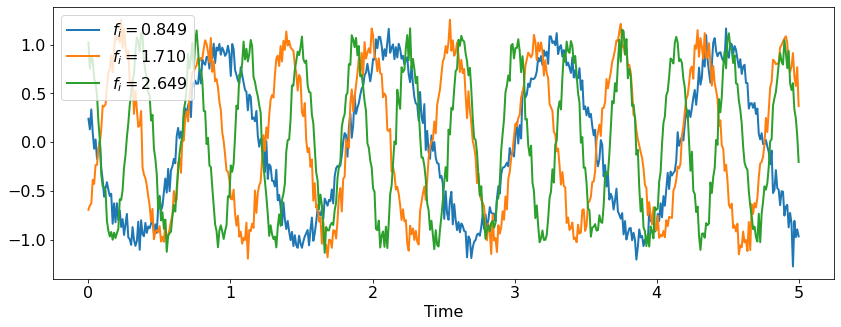

In [7]:
plt.figure(figsize=(14,5))
for _ in range(3):
    idx = np.random.randint(nTrain)
    vX  = mX[idx,:]
    plt.plot(t, vX, lw=2, label=f'$f_i = {(vF[idx].item()):.3f}$')

plt.xlabel('Time')
plt.legend()
plt.show  ()

#### Input data: (N x Channels X Length)
The input to 1D CNN is `NxCxL` so we use `view` to add a new axis (`unsqueeze` will work as well).

In [8]:
mX = mX.view(nTrain, 1, -1) #-- N x Channels x Length
mX.shape 

torch.Size([10000, 1, 500])

#### Split data to train and validation:

In [9]:
oDataSet            = torch.utils.data.TensorDataset(mX, vF)
oTrainSet, oValSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * nTrain, 0.1 * nTrain]).astype(int))
len(oTrainSet), len(oValSet)

(9000, 1000)

#### Create data loaders:

In [10]:
batchSize = 512
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize)

#### Define the model (1D CNN):

In [11]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

from DeepLearningFramework.Layers import Squeeze

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv1d(in_channels=1,   out_channels=32,  kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=32,  out_channels=64,  kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=64,  out_channels=128, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size=1),
        nn.Flatten(),
        nn.Linear(in_features=256, out_features=1),
        Squeeze(),
    )
    
    return oModel

#-- Model summary:
torchsummary.summary(GetModel(), mX[0,:,:].shape, device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1               [-1, 1, 500]               0
            Conv1d-2              [-1, 32, 490]             384
         MaxPool1d-3              [-1, 32, 245]               0
              ReLU-4              [-1, 32, 245]               0
            Conv1d-5              [-1, 64, 235]          22,592
         MaxPool1d-6              [-1, 64, 117]               0
              ReLU-7              [-1, 64, 117]               0
            Conv1d-8             [-1, 128, 107]          90,240
         MaxPool1d-9              [-1, 128, 53]               0
             ReLU-10              [-1, 128, 53]               0
           Conv1d-11              [-1, 256, 43]         360,704
        MaxPool1d-12              [-1, 256, 21]               0
             ReLU-13              [-1, 256, 21]               0
AdaptiveAvgPool1d-14               [-1,

#### Check whether GPU is available:

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
DEVICE

device(type='cuda')

In [13]:
oModel  = GetModel().to(DEVICE)
oOptim  = optim.Adam(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99))
Loss    = nn.MSELoss()
nEpochs = 30

TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 27.155 | Val loss: 16.626 | Train R2: -2.274 | Val R2: -1.018 | epoch time:  1.532 |
Epoch 001: | Train loss:  8.138 | Val loss:  4.805 | Train R2: +0.017 | Val R2: +0.417 | epoch time:  0.301 | <-- Checkpoint!
Epoch 002: | Train loss:  3.391 | Val loss:  1.827 | Train R2: +0.592 | Val R2: +0.778 | epoch time:  0.292 | <-- Checkpoint!
Epoch 003: | Train loss:  1.175 | Val loss:  0.473 | Train R2: +0.859 | Val R2: +0.943 | epoch time:  0.264 | <-- Checkpoint!
Epoch 004: | Train loss:  0.311 | Val loss:  0.199 | Train R2: +0.962 | Val R2: +0.976 | epoch time:  0.276 | <-- Checkpoint!
Epoch 005: | Train loss:  0.170 | Val loss:  0.111 | Train R2: +0.979 | Val R2: +0.986 | epoch time:  0.277 | <-- Checkpoint!
Epoch 006: | Train loss:  0.090 | Val loss:  0.054 | Train R2: +0.989 | Val R2: +0.993 | epoch time:  0.270 | <-- Checkpoint!
Epoch 007: | Train loss:  0.050 | Val loss:  0.032 | Train R2: +0.994 | Val R2: +0.996 | epoch time:  0.281 | <-- Checkpoint!
Epoch 00

### Test the model:

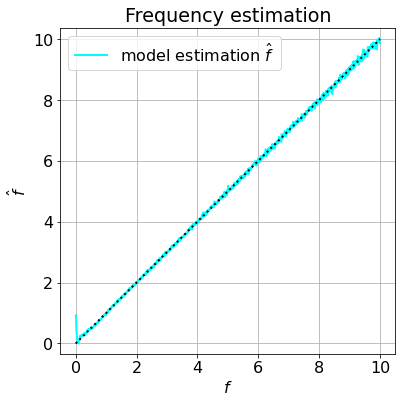

In [14]:
nTest  = 1001

#-- Generate test data:
vTestF = torch.linspace(0, 10, nTest)
mTestX = torch.sin(2 * π * vTestF[:,None] @ t[None,:])
mTestX = mTestX + σ * torch.randn(mTestX.shape)

#-- Apply model:
with torch.no_grad():
    vHatTestF = oModel(mTestX.view(nTest,1,-1).to(DEVICE)).squeeze()
vHatTestF = vHatTestF.detach().cpu() #-- move to CPU

plt.figure(figsize=(6, 6))
plt.plot  (vTestF, vHatTestF, 'cyan', lw=2, label='model estimation $\hat{f}$')
plt.plot  (vTestF, vTestF,   ':k',    lw=2)
plt.title ('Frequency estimation')
plt.xlabel('$f$')
plt.ylabel('$\hat{f}$')
plt.axis  ('equal')
plt.legend()
plt.grid  ()
plt.show  ()


### Question:
What will happen (and why) if we change (line 4):<br>
`vTestF = torch.linspace(0, 10, Ntest)`  
into  
`vTestF = torch.linspace(0, 15, Ntest)`  
?